In [5]:
import matlab.engine
from heartnet_v1 import heartnet
import numpy as np
import flask
import io

# app=flask.Flask(__name__)
model=None

load_path='/media/taufiq/Data/heart_sound/models/fold1_noFIR 2018-02-02 09:52:02.463256/weights.0148-0.8902.hdf5'

Using TensorFlow backend.


In [12]:
def preprocessing(PCG,eng,target_fs,in_fs):
    PCG = eng.resample(PCG,matlab.double([target_fs]),matlab.double([in_fs]))
    PCG = eng.butterworth_low_pass_filter(PCG,matlab.double([2]),matlab.double([400]),matlab.double([1000]))
    PCG = eng.butterworth_high_pass_filter(PCG,matlab.double([2]),matlab.double([25]),matlab.double([1000]))
    PCG = eng.schmidt_spike_removal(PCG,matlab.double([target_fs]))
    return PCG

In [6]:
def matlab_init():
    eng = matlab.engine.start_matlab()
    eng.addpath('/media/taufiq/Data/heart_sound/Heart_Sound/codes/cristhian.potes-204/');
    return eng

In [25]:
def segmentation(PCG,eng):
    assigned_states = eng.runSpringerSegmentationAlgorithmpython(PCG,matlab.double([target_fs]))
    idx_states,last_idx=eng.get_states_python(assigned_states,nargout=2)
    
    ncc=len(idx_states)
    idx_states=np.hstack(np.asarray(idx_states))
    idx_states=np.reshape(idx_states,(ncc,4))
    idx_states=idx_states-1 ## -1 for python indexing compatibility 
    last_idx=last_idx-1
    PCG = np.hstack(np.asarray(PCG))
    x = np.zeros([ncc,nsamp],dtype=np.double)
    PCG = PCG/np.max(PCG)
    
    for row in range(ncc):
        if row == ncc-1:
            tmp = PCG[int(idx_states[row,0]):int(last_idx-1)] ## 2 to compensate for python indexing
        else:
            tmp=PCG[int(idx_states[row,0]):int(idx_states[row+1,0]-1)]
        N = nsamp-tmp.shape[0]
        x[row,:] = np.concatenate((tmp,np.zeros(N)))
    x = np.reshape(x,(x.shape[0],x.shape[1],1))
    return x

In [29]:
@app.route("/predict")
def predict():
    return 'Test server running'

In [30]:
if __name__=='__main__':
    app.run(debug=True,port=5000)

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat


SystemExit: 1

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [29]:
with open('Output.txt', 'r') as myfile:
    data=myfile.read()

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from scipy.io.wavfile import read

In [31]:
parsed= np.fromstring(data,np.int16)

20


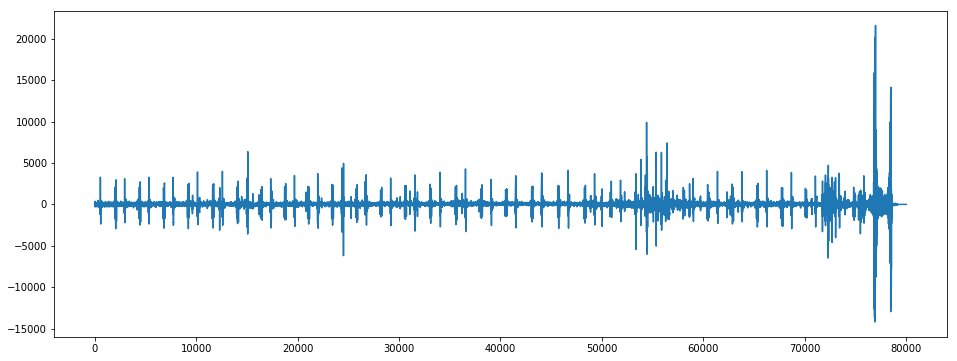

In [35]:
print(parsed.shape[0]/4000)
plt.figure(figsize=(16,6))
plt.plot(parsed.astype(np.float32))
plt.show()

In [7]:
eng = matlab_init()

In [13]:
parsed_ = np.ndarray.tolist(parsed)
ret = preprocessing(matlab.double([parsed_]),eng,1000,4000)

In [15]:
ret=np.hstack(np.asarray(ret))

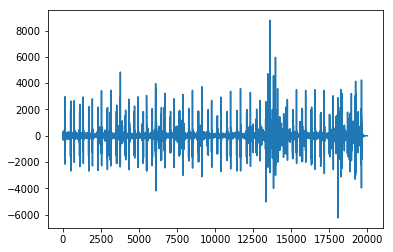

In [18]:
plt.plot(ret)
write('pre-processed.wav',1000,ret)

In [25]:
fs,ret = read(filename='pre-processed.wav')

numpy.ndarray